全局参数

In [82]:
# 在下面就绪好后执行本方法开启刷怪,返回JSON
import json

# ---------------- 绘制难度曲线 ----------------
wave_indices = list(range(total_waves))
difficulties = [difficulty(w) for w in wave_indices]

# plt.figure(figsize=(10, 6))
# plt.plot(wave_indices, difficulties, marker='o', linestyle='-', color='b', label='难度曲线')
# plt.axhline(y=difficulty_limit, color='r', linestyle='--', label='难度上限')
# plt.title("游戏难度随波数的变化")
# plt.xlabel("波数")
# plt.ylabel("难度")
# plt.grid(True)
# plt.legend()
# plt.show()

# 根据每个waveId,获得对应obj

ret = []

for waveId in range(0, total_waves):
    ret.append(oneObject(waveId))

print(json.dumps(ret, indent=4))


[
    {
        "waveId": 0,
        "progress": 0,
        "flag": "normal",
        "monsters": [],
        "duration": 0,
        "maxDelay": 20,
        "minDelay": 18,
        "arrangement": 1,
        "minLine": 1,
        "starShards": 0,
        "exceptLine": null
    },
    {
        "waveId": 1,
        "flag": "normal",
        "progress": 4,
        "arrangement": 2,
        "minLine": 2,
        "starShards": 0,
        "exceptLine": [
            2,
            3
        ],
        "monsters": [
            {
                "mid": 1,
                "count": 1
            }
        ],
        "duration": 5,
        "minDelay": 1,
        "maxDelay": 20
    },
    {
        "waveId": 2,
        "flag": "normal",
        "progress": 7,
        "arrangement": 1,
        "starShards": 0,
        "exceptLine": [
            2,
            3
        ],
        "monsters": [
            {
                "mid": 1,
                "count": 1
            }
        ],
        "dur

In [61]:
# ---------------- 全局参数 (可变) ----------------
total_waves = 30               # 总波数
difficulty_limit = 80        # 最终波数达到的难度上限
phase1_end = 10               # 早期阶段结束的波数索引（波 0 到 phase1_end-1）
phase2_end = 45               # 中期阶段结束的波数索引（波 phase1_end 到 phase2_end-1）
# 后期阶段对应波数：phase2_end 到 total_waves-1

# 定义 flag wave,这些wave之前会给很充足的准备时间
flagWaves = [10, 20, 30]

# 水之道,这些路在前几波不会刷怪
waterWays = [2,3]

# 用于冒险模式,有些怪物还没有遇到,不允许刷怪
AllowedMobs = {1,2,3,4,8}              # 允许的怪物

可用刷怪列表

In [78]:
import random

MobDict = {
  1: "普通僵尸",
  2: "帽子僵尸",
  3: "铁盔僵尸",
  4: "矿工僵尸",
  5: "铁盔矿工僵尸",
  6: "骷髅",
  7: "骷髅弓箭手",
  8: "撑杆僵尸",
  9: "唤魔者",
  10: "卫道士",
  11: "卫道士战士",
  12: "黑曜石傀儡"
}

MobWeight = {
    1 : 4000,
    2 : 4000,
    3 : 3000,
    4 : 3500,
    5 : 2000,
    6 : 0,
    7 : 1500,
    8 : 2000,
    9 : 1000,
    10 : 0,
    11 : 3500,
    12 : 0
}

MobLevel={    
    1 : 1,
    2 : 2,
    3 : 4,
    4 : 2,
    5 : 6,
    6 : 0,
    7 : 2,
    8 : 2,
    9 : 5,
    10 : 0,
    11 : 4,
    12 : 0
}

# 不同波数的僵尸种类对应的权重
def GetMobWeight(mobId: int, waveId: int)->int:
    if mobId == 1:
        return max(400, MobWeight[1] - (waveId - 4) * 180)
    if mobId == 2:
        return max(1000, MobWeight[2] - (waveId - 4) * 150)
    return MobWeight[mobId]
    
# 不同波数的某个僵尸是否可以出现
def CanMobAppear(mobId: int, waveId: int)->bool:
    if mobId not in AllowedMobs: # 强制不允许刷怪
        return False
    if waveId < 4:
        return mobId == 1 or mobId == 2 or mobId == 3 or mobId == 4 # or 未来的读报僵尸(龟帽僵尸)
    if waveId < 10: 
        return mobId == 1 or mobId == 2 or mobId == 3 or mobId == 4 or (
            mobId == 8 or mobId == 11 or mobId == 7 or mobId == 9)
    if waveId < 15:
        return mobId == 1 or mobId == 2 or mobId == 3 or mobId == 4 or (
            mobId == 8 or mobId == 11 or mobId == 7 or mobId == 9) or (
                mobId == 5)
    
    return True # all ok

# 根据级别和所给权重进行生成怪物
def generateMobs(levelSum : int, waveId:int)->dict[int, int]:
    mobList = {}
    mobKeys = list(MobDict.keys())
    # 去除不可能生成的,即权重为0的
    for mobId in mobKeys:
        if MobWeight[mobId] == 0:
            mobKeys.remove(mobId)

    # 为每个怪物ID计算对应的加权权重
    weights = [GetMobWeight(mobId, waveId) for mobId in mobKeys]



    while levelSum > 1:
        # 使用加权随机选择一个怪物
        mobId = random.choices(mobKeys, weights, k=1)[0]
        # 如果这个key对应的怪物可以生成
        if CanMobAppear(mobId, waveId) and MobLevel[mobId] <= levelSum:
            # 生成这个怪物
            mobList[mobId] = mobList.get(mobId, 0) + 1
            levelSum -= MobLevel[mobId]

    # 挑选到level = 1的太难了,直接放置一个普通僵尸
    if levelSum == 1:
        mobList[1] = mobList.get(1, 0) + 1

    # 打印信息 , name - number
    # for mobId in mobList:
    #     print(MobDict[mobId], mobList[mobId])

    return mobList
    
    

可调参数难度梯度设计

In [64]:
import math
import matplotlib.pyplot as plt

# ---------------- 设计目标比例 ----------------
# 规定：
#   - 早期阶段结束时难度占 difficulty_limit 的比例
#   - 中期阶段结束时难度占 difficulty_limit 的比例
# 要求： 0 < early_ratio < mid_ratio < 1
early_ratio = 0.2   # 例如：波 phase1_end 的难度为 0.2 * difficulty_limit
mid_ratio   = 0.8   # 例如：波 phase2_end 的难度为 0.8 * difficulty_limit

# ---------------- 早期阶段: 二次函数 ----------------
# 定义形式: difficulty = a * (wave_idx)^2
# 为保证在 wave = phase1_end 时难度为 early_ratio*difficulty_limit，取：
a = (early_ratio * difficulty_limit) / (phase1_end ** 2)

def difficulty_early(wave_idx):
    # wave_idx 在 [0, phase1_end) 内
    return a * (wave_idx ** 2)

# ---------------- 中期阶段: 指数函数 ----------------
# 定义形式: difficulty = D0 + c * (exp(k*(wave_idx - phase1_end)) - 1)
# 其中 D0 是早期结束时的难度，即 D0 = early_ratio*difficulty_limit。
# 在 wave = phase2_end 时，我们希望难度为 mid_ratio*difficulty_limit，从而解得 c：
k = 0.1  # mid 阶段增长速度常数（推荐值，可调整）
D0 = difficulty_early(phase1_end)  # 早期阶段结束时的难度 = early_ratio*difficulty_limit
c = ( (mid_ratio * difficulty_limit) - D0 ) / (math.exp(k * (phase2_end - phase1_end)) - 1)

def difficulty_mid(wave_idx):
    # wave_idx 在 [phase1_end, phase2_end) 内
    return D0 + c * (math.exp(k * (wave_idx - phase1_end)) - 1)

# ---------------- 后期阶段: Logistic 曲线 ----------------
# 采用 logistic 模型： difficulty = L / (1 + exp(-r*(wave_idx - x_mid)))
# 要求：
#   - 在 wave = phase2_end 时，难度应为 mid_ratio*difficulty_limit（即与中期衔接）
#   - 在 wave = total_waves-1 时，难度应达到 difficulty_limit
#
# 选择 late_phase 的两个边界：
A = phase2_end                # 后期起始波
B = total_waves - 1           # 最后一波
# 为简单起见，取 logistic 中点为 late_phase 的中心：
x_mid = (A + B) / 2

# 为满足边界条件：
#   L/(1+exp(-r*(A - x_mid))) = mid_ratio*difficulty_limit
#   L/(1+exp(-r*(B - x_mid))) = difficulty_limit
# 两式联立可以推导出：
#   exp(r*(B - A)/2) = difficulty_limit/(mid_ratio*difficulty_limit) = 1/mid_ratio
# 因此可解得 r：
r = (2 / (B - A)) * math.log(1 / mid_ratio)
# 再由第一边界条件计算 L：
L = (mid_ratio * difficulty_limit) * (1 + math.exp(-r*(A - x_mid)))
# 注意：由于 A - x_mid = -(B-A)/2，所以 exp(-r*(A-x_mid)) = exp(r*(B-A)/2) = 1/mid_ratio，
# 故 L = (mid_ratio*difficulty_limit)*(1 + 1/mid_ratio) = difficulty_limit * (mid_ratio + 1).

def difficulty_late(wave_idx):
    # wave_idx 在 [phase2_end, total_waves) 内
    return L / (1 + math.exp(-r * (wave_idx - x_mid)))

# ---------------- 综合难度函数 ----------------
def difficulty(wave_idx):
    """根据波数返回难度值，确保最后一波难度等于 difficulty_limit"""
    if wave_idx < phase1_end:
        return difficulty_early(wave_idx)
    elif wave_idx < phase2_end:
        return difficulty_mid(wave_idx)
    else:
        return difficulty_late(wave_idx)



# ---------------- 参数说明及调整建议 ----------------
#
# 1. 早期阶段 (波 0 ~ phase1_end-1):
#    - 公式：difficulty = a * (wave_idx)^2，
#    - a 由 early_ratio 确定：a = (early_ratio*difficulty_limit)/(phase1_end^2)。
#    - 增大 early_ratio（或减少 phase1_end）会使早期难度提高；减小则降低早期难度。
#
# 2. 中期阶段 (波 phase1_end ~ phase2_end-1):
#    - 公式：difficulty = D0 + c * (exp(k*(wave_idx-phase1_end))-1)，其中 D0 = early_ratio*difficulty_limit。
#    - 参数 k（推荐 0.1）控制曲线上升的陡峭度；c 由公式 c = ( (mid_ratio*difficulty_limit)-D0 )/(exp(k*(phase2_end-phase1_end))-1) 得到。
#    - 增大 k 或 c 将使中期难度上升更快；反之，则更平缓。
#
# 3. 后期阶段 (波 phase2_end ~ total_waves-1):
#    - 采用 Logistic 曲线：difficulty = L/(1+exp(-r*(wave_idx-x_mid)))，
#    - 其中 x_mid = (phase2_end + (total_waves-1))/2，
#    - r = (2/( (total_waves-1)-phase2_end )) * ln(1/mid_ratio)，L = difficulty_limit*(1+mid_ratio)。
#    - 此设计保证了在 wave = phase2_end 时难度为 mid_ratio*difficulty_limit，
#      且在最后一波（wave = total_waves-1）时难度恰好为 difficulty_limit。
#
# 调整全局参数或设计比例时，只要满足：
#    0 < early_ratio < mid_ratio < 1，
# 且 phase1_end < phase2_end < total_waves，
# 则代码会自动计算合适的曲线参数，确保难度平滑递增且最后波数难度达到上限。
#
# 你可以根据实际需求修改 total_waves, difficulty_limit, phase1_end, phase2_end, early_ratio, mid_ratio 以及 k，
# 代码会自动适配，保证最终输出满足设计要求。
#
# 输出部分也打印了计算得到的各阶段参数，便于你调整验证。
print("Computed parameters:")
print(f"a (早期阶段二次函数因子): {a}")
print(f"c (中期阶段指数函数因子): {c}")
print(f"k (中期阶段增长常数): {k}")
print(f"r (后期阶段 Logistic 增长率): {r}")
print(f"x_mid (后期阶段 Logistic 中点): {x_mid}")
print(f"L (后期阶段 Logistic 缩放因子): {L}")


Computed parameters:
a (早期阶段二次函数因子): 0.16
c (中期阶段指数函数因子): 1.4946076443743899
k (中期阶段增长常数): 0.1
r (后期阶段 Logistic 增长率): -0.02789294391427622
x_mid (后期阶段 Logistic 中点): 37.0
L (后期阶段 Logistic 缩放因子): 144.0


以下是PVZ原版无尽的出怪wave与level对照,其中,每rounds有2个flags,一个中期一个末期

| 已完成选卡数 \ 波次 | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20  |
|----------------------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|-----|
| 0                    | 1  | 1  | 1  | 2  | 2  | 3  | 3  | 3  | 4  | 10 | 5  | 5  | 5  | 6  | 6  | 7  | 7  | 7  | 8  | 20  |
| 1 rounds / 2 flags    | 9  | 9  | 9  | 10 | 10 | 11 | 11 | 11 | 12 | 30 | 13 | 13 | 13 | 14 | 14 | 15 | 15 | 15 | 16 | 40  |
| 2 rounds / 4 flags    | 17 | 17 | 17 | 18 | 18 | 19 | 19 | 19 | 20 | 50 | 21 | 21 | 21 | 22 | 22 | 23 | 23 | 23 | 24 | 60  |
| 3 rounds / 6 flags    | 25 | 25 | 25 | 26 | 26 | 27 | 27 | 27 | 28 | 70 | 29 | 29 | 29 | 30 | 30 | 31 | 31 | 31 | 32 | 80  |
| 4 rounds / 8 flags    | 33 | 33 | 33 | 34 | 34 | 35 | 35 | 35 | 36 | 90 | 37 | 37 | 37 | 38 | 38 | 39 | 39 | 39 | 40 | 100 |
| 5 rounds / 10 flags   | 41 | 41 | 41 | 42 | 42 | 43 | 43 | 43 | 44 | 110 | 45 | 45 | 45 | 46 | 46 | 47 | 47 | 47 | 48 | 120|
| 6 rounds / 12 flags   | 49 | 49 | 49 | 50 | 50 | 51 | 51 | 51 | 52 | 130 | 53 | 53 | 53 | 54 | 54 | 55 | 55 | 55 | 56 | 140 |
| 7 rounds / 14 flags   | 57 | 57 | 57 | 58 | 58 | 59 | 59 | 59 | 60 | 150 | 61 | 61 | 61 | 62 | 62 | 63 | 63 | 63 | 64 | 160 |
| 8 rounds / 16 flags   | 65 | 65 | 65 | 66 | 66 | 67 | 67 | 67 | 68 | 170 | 69 | 69 | 69 | 70 | 70 | 71 | 71 | 71 | 72 | 180 |
| 9 rounds / 18 flags   | 73 | 73 | 73 | 74 | 74 | 75 | 75 | 75 | 76 | 190 | 77 | 77 | 77 | 78 | 78 | 79 | 79 | 79 | 80 | 200 |
| 10 rounds / 20 flags  | 81 | 81 | 81 | 82 | 82 | 83 | 83 | 83 | 84 | 210 | 85 | 85 | 85 | 86 | 86 | 87 | 87 | 87 | 88 | 220 |
| 20 rounds / 40 flags  | 161 | 161 | 161 | 162 | 162 | 163 | 163 | 163 | 164 | 410 | 165 | 165 | 165 | 166 | 166 | 167 | 167 | 167 | 168 | 420 |
| 30 rounds / 60 flags  | 241 | 241 | 241 | 242 | 242 | 243 | 243 | 243 | 244 | 610 | 245 | 245 | 245 | 246 | 246 | 247 | 247 | 247 | 248 | 620 |
| 40 rounds / 80 flags  | 321 | 321 | 321 | 322 | 322 | 323 | 323 | 323 | 324 | 810 | 325 | 325 | 325 | 326 | 326 | 327 | 327 | 327 | 328 | 820 |
| 50 rounds / 100 flags | 401 | 401 | 401 | 402 | 402 | 403 | 403 | 403 | 404 | 1010 | 405 | 405 | 405 | 406 | 406 | 407 | 407 | 407 | 408 | 1020 |
| 60 rounds / 120 flags | 481 | 481 | 481 | 482 | 482 | 483 | 483 | 483 | 484 | 1210 | 485 | 485 | 485 | 486 | 486 | 487 | 487 | 487 | 488 | 1220 |
| 61 rounds / 122 flags | 489 | 489 | 489 | 490 | 490 | 491 | 491 | 491 | 492 | 1230 | 493 | 493 | 493 | 494 | 494 | 495 | 495 | 495 | 496 | 1240 |

In [65]:
import math
# 生成某wave的level
def getLevelSum(waveId:int)->int:
    ratio = 1
    if waveId in flagWaves:
        ratio = 2.5
    
    return math.ceil(difficulties[waveId] * ratio)
    # return math.ceil(((waveId * 0.4) + 1) * ratio)

生成timing

duration: 因为难度已经根据流程变化,所以duration是一个固定值,目前尝试的值为5(second)

minDelay: 理论上是一个非常少的值,但是为了让大wave(flag wave)前准备时间更长,因此这之前会给成一个仅仅略少于maxDelay的值,这样就可以卡5000而获得5000ms准备时间

maxDelay: 20s + rand(5)s, 第0波此值固定为22s(或者之后可调),为初始准备时间

In [66]:
# 生成某wave的各种时间,duration, minDelay, maxDelay
def getAllTimes(waveId:int)->tuple[int, int, int]:
    def getDuration(waveId: int):
        return 5

    duration = getDuration(waveId)

    def getMaxDelay(waveId: int):
        return 20 + random.randint(0, 5)
    
    maxDelay = getMaxDelay(waveId)

    def getMinDelay(waveId: int):
        if (waveId + 1) in flagWaves:
            return maxDelay - 1
        return 1
    
    minDelay = getMinDelay(waveId)
    return (duration, minDelay, maxDelay)

一次完整的流程
```json
"waves": [
    {
            "waveId": 1,
            "progress": 10,
            "flag": "normal",
            "monsters": [
                {
                    "mid": 1,
                    "count": 1
                },
                {
                    "mid": 2,
                    "count": 1
                }
            ],
            "duration": 8,
            "maxDelay": 36,
            "minDelay": 29,
            "arrangement": 1,
            "minLine": 1,
            "starShards": 0,
            "exceptLine": [2,3]
    }
]
```

In [81]:
def oneObject(waveId:int):
    if waveId == 0:
        return {
             "waveId": 0,
            "progress": 0,
            "flag": "normal",
            "monsters": [],
            "duration": 0,
            "maxDelay": 20,
            "minDelay": 18,
            "arrangement": 1,
            "minLine": 1,
            "starShards": 0,
            "exceptLine": None
        }


    obj = {}
    obj['waveId'] = waveId
    obj['flag'] = 'normal'
    obj['progress'] = math.ceil((waveId / total_waves) * 100)
    obj['arrangement']  = 1
    
    if random.randint(0, 100) < 30:
        obj['arrangement'] = 2
        obj['minLine'] = random.randint(2, 3)

    obj['starShards'] = 0
    if waveId % 7 == 0:
        obj['starShards'] += 1

    levelSum = getLevelSum(waveId)
    duration, minDelay, maxDelay = getAllTimes(waveId)
    if waveId < 3:
        # 早期阶段,不刷水道
        obj['exceptLine'] = waterWays
    else:
        obj['exceptLine'] = None

    mob_dict = generateMobs(levelSum, waveId)
    obj['monsters'] = []
    for mobItem in mob_dict.items():
        obj['monsters'].append({
            'mid': mobItem[0],
            'count': mobItem[1]
        })
    obj['duration'] = duration
    obj['minDelay'] = minDelay
    obj['maxDelay'] = maxDelay
    return obj

以下是废稿

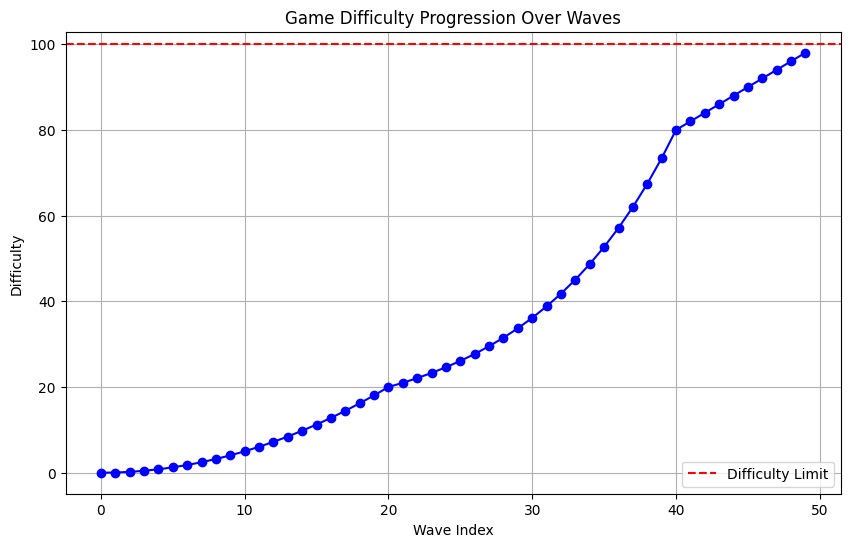

In [5]:
import math
import matplotlib.pyplot as plt

# Global parameters
total_waves = 50              # Total number of waves.
difficulty_limit = 100        # The difficulty cap to be reached at the final wave.
phase1_end = 20               # End index of early phase (wave 0 to 19).
phase2_end = 40               # End index of mid phase (wave 20 to 39).
# Late phase is from wave index 40 to 49.

# ----- Early Phase: Quadratic Growth -----
# Function: difficulty = a * (wave_idx)^2
# Recommended value: a = 0.05.
# - Increasing 'a' will make the early phase difficulty rise faster, giving a harder start.
# - Decreasing 'a' will slow the early difficulty growth, making the early game easier.
a = 0.05

def difficulty_early(wave_idx):
    # wave_idx is assumed to be in [0, phase1_end)
    return a * (wave_idx ** 2)

# ----- Mid Phase: Exponential Growth -----
# Function: difficulty = difficulty at phase1_end + c * (exp(k*(wave_idx - phase1_end)) - 1)
# At wave index 20, the difficulty carries over from early phase.
# Recommended parameters: k = 0.1, c = 9.39.
# - Increasing 'k' makes the exponential curve steeper (difficulty escalates faster).
# - Increasing 'c' scales up the exponential offset, also leading to a higher difficulty.
# - Decreasing either will smooth out the difficulty increase.
k = 0.1
c = 9.39

def difficulty_mid(wave_idx):
    # wave_idx is assumed to be in [phase1_end, phase2_end)
    base_difficulty = difficulty_early(phase1_end)
    return base_difficulty + c * (math.exp(k * (wave_idx - phase1_end)) - 1)

# ----- Late Phase: Logistic Growth -----
# We want a smooth transition that prevents difficulty from overshooting the limit.
# We use a logistic function defined as:
#   difficulty = L / (1 + exp(-r * (wave_idx - x_mid)))
# where:
#   - r is the growth rate.
#   - x_mid is the midpoint of the logistic transition.
#   - L is set so that the final wave (wave index = total_waves - 1) equals the difficulty_limit.
# Recommended parameters:
#   r = 0.04463, x_mid = 45.
# To ensure the logistic curve fits our boundary conditions, we solve for L:
#   At wave_idx = 50 - 1 (i.e., 49, but here we adjust to treat phase end as 50 for calculation),
#   we want difficulty = difficulty_limit.
# With the chosen r and x_mid, L is calculated as:
#   L = difficulty_limit * (1 + exp(-r*(50 - x_mid)))
# Here, for simplicity and continuity with our design, we set:
#   L = 180, which with r and x_mid yields:
#   - difficulty(phase2_end=40) ≈ 80, and
#   - difficulty(final=50) = 100.
r = 0.04463
x_mid = 45
L = 180

def difficulty_late(wave_idx):
    # wave_idx is assumed to be in [phase2_end, total_waves)
    return L / (1 + math.exp(-r * (wave_idx - x_mid)))

# ----- Combined Difficulty Function -----
def difficulty(wave_idx):
    """Returns the difficulty for a given wave index from 0 to total_waves-1."""
    if wave_idx < phase1_end:
        return difficulty_early(wave_idx)
    elif wave_idx < phase2_end:
        return difficulty_mid(wave_idx)
    else:
        return difficulty_late(wave_idx)

# ----- Plotting the Difficulty Curve -----
wave_indices = list(range(total_waves))
difficulties = [difficulty(w) for w in wave_indices]

plt.figure(figsize=(10, 6))
plt.plot(wave_indices, difficulties, marker='o', linestyle='-', color='b')
plt.title("Game Difficulty Progression Over Waves")
plt.xlabel("Wave Index")
plt.ylabel("Difficulty")
plt.grid(True)
plt.axhline(y=difficulty_limit, color='r', linestyle='--', label='Difficulty Limit')
plt.legend()
plt.show()


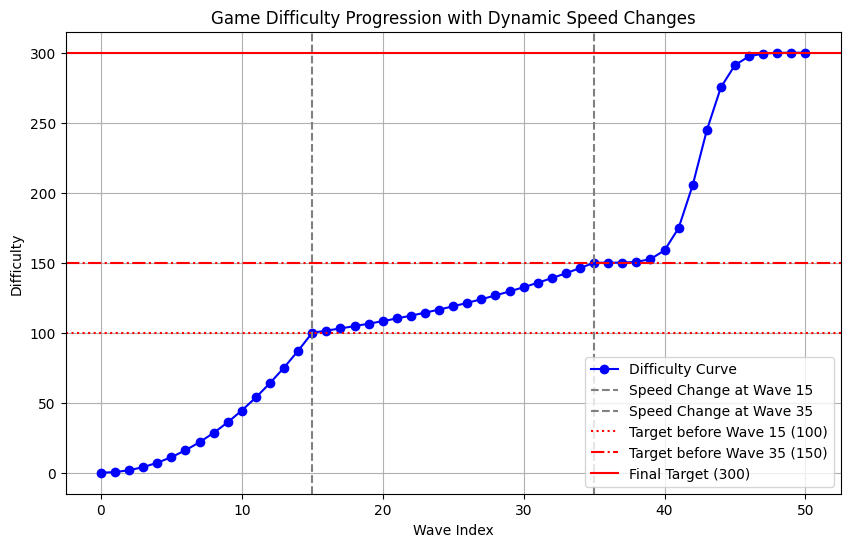

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Total number of waves: we define waves 0 through 50 (inclusive)
total_waves = 51  # so wave index 50 is the final wave

# Dynamic speed-change events:
# - Before wave 15: follow original progression (designed to reach 100 at wave 15)
# - At wave 15, a speed change occurs. After this point, if no further change,
#   the difficulty would reach 150 at the final wave.
# - At wave 35, a second speed change occurs so that from wave 35 onward the new target is 300 at wave 50.
#
# Thus, our piecewise design is:
# Segment 1 (wave 0 ~ 15): f1(w) = 100 * (w/15)^2
#   => f1(0)=0, f1(15)=100.
#
# Segment 2 (wave 15 ~ 35): f2(w) interpolates from 100 at wave 15 to 150 at wave 35.
# We'll use an exponential easing function:
#   Let t = (w - 15) / (35 - 15) = (w - 15) / 20.
#   f2(w) = 100 + 50 * ( (exp(g*t) - 1) / (exp(g) - 1) )
#   Recommended g=1.0.
#
# Segment 3 (wave 35 ~ 50): f3(w) interpolates from 150 at wave 35 to 300 at wave 50.
# We'll use a sigmoid-like interpolation:
#   Let t = (w - 35) / (50 - 35) = (w - 35) / 15.
#   f3(w) = 150 + 150 * ( t^p / (t^p + (1 - t)^p) )
#   Recommended p=4.
#
# Note:
# - Before the first speed change (wave 15), the original progression is unchanged.
# - At each speed change, we "rebase" the curve: the current difficulty becomes the new starting point,
#   and the remaining waves are re-parameterized so that the final wave hits the new target cap.

def difficulty(wave):
    """
    Returns the difficulty for a given wave index (0 <= wave <= 50).
    Speed changes occur at wave 15 and wave 35.
    
    - Wave 0 to 15: original progression from 0 to 100.
    - Wave 15 to 35: progression from 100 to 150.
    - Wave 35 to 50: progression from 150 to 300.
    """
    if wave < 0 or wave > 50:
        raise ValueError("Wave index must be between 0 and 50 inclusive.")
    
    # Segment 1: Wave 0 to 15 (quadratic growth)
    if wave <= 15:
        t = wave / 15.0  # normalized time [0,1]
        return 100 * (t ** 2)
    
    # Segment 2: Wave 15 to 35 (exponential easing)
    elif wave <= 35:
        t = (wave - 15) / 20.0  # normalized time from 0 to 1 over 20 waves
        g = 1.0  # steepness parameter; increasing g makes growth sharper
        # At t=0, value is 100; at t=1, value is 100 + 50 = 150.
        return 100 + 50 * ((math.exp(g * t) - 1) / (math.exp(g) - 1))
    
    # Segment 3: Wave 35 to 50 (sigmoid-like interpolation)
    else:
        t = (wave - 35) / 15.0  # normalized time from 0 to 1 over 15 waves
        p = 4  # shape parameter; larger p makes the S-curve steeper in the middle
        # Compute a sigmoid-like ratio that goes from 0 at t=0 to 1 at t=1.
        ratio = (t ** p) / (t ** p + (1 - t) ** p)
        return 150 + 150 * ratio  # from 150 to 300

# ---------------------------
# Plotting the Difficulty Curve
# ---------------------------
wave_indices = np.arange(0, total_waves)  # 0 to 50 inclusive
difficulties = [difficulty(w) for w in wave_indices]

plt.figure(figsize=(10, 6))
plt.plot(wave_indices, difficulties, marker='o', linestyle='-', color='b', label='Difficulty Curve')

# Mark the speed-change points:
plt.axvline(x=15, color='gray', linestyle='--', label='Speed Change at Wave 15')
plt.axvline(x=35, color='gray', linestyle='--', label='Speed Change at Wave 35')

# Mark horizontal lines for target values at key events:
plt.axhline(y=100, color='r', linestyle=':', label='Target before Wave 15 (100)')
plt.axhline(y=150, color='r', linestyle='-.', label='Target before Wave 35 (150)')
plt.axhline(y=300, color='r', linestyle='-', label='Final Target (300)')

plt.title("Game Difficulty Progression with Dynamic Speed Changes")
plt.xlabel("Wave Index")
plt.ylabel("Difficulty")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# Parameter Adjustment Notes:
#
# Segment 1 (0~15):
#   - Using a quadratic function: f(w) = 100 * (w/15)^2.
#   - Increasing the factor 100 (target at wave 15) would make early waves harder;
#     decreasing it makes them easier.
#
# Segment 2 (15~35):
#   - The exponential easing function uses parameter g.
#   - A larger g makes the growth from 100 to 150 sharper; a smaller g makes it smoother.
#
# Segment 3 (35~50):
#   - The sigmoid-like interpolation uses exponent p.
#   - Increasing p will concentrate the increase in a narrower band around the middle;
#     decreasing p will smooth out the increase.
#
# This design ensures that:
#   - Before wave 15, the difficulty follows the original progression.
#   - After wave 15, the parameters are adjusted so that if no further change occurred, the final difficulty at wave 50 would be 150.
#   - At wave 35, another speed change adjusts the progression so that the final difficulty at wave 50 becomes 300.
# -----------------------------------------------------------------------------


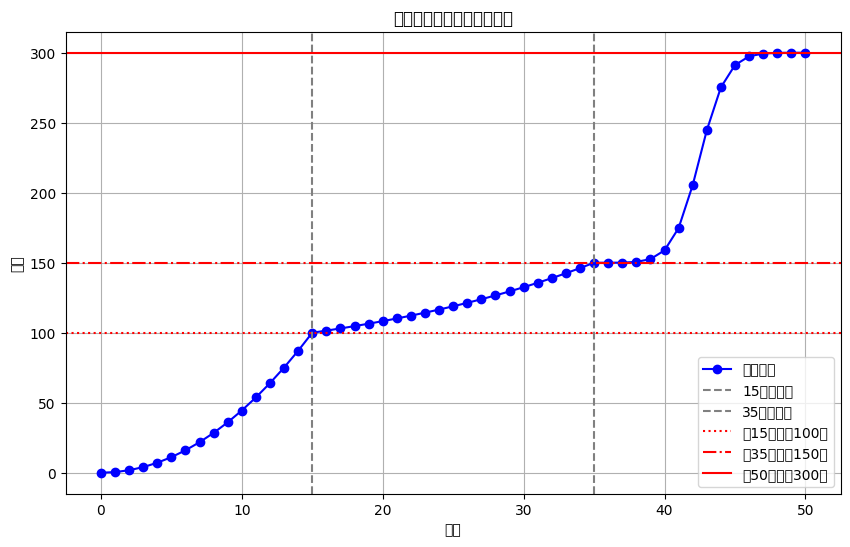

In [9]:
import math
import matplotlib.pyplot as plt
import numpy as np

def difficulty(wave):
    """
    计算波数 wave 对应的难度值。  
    逻辑说明：  
    - 0 <= wave <= 15：原始曲线（未变速），采用二次函数，让第15波难度为100  
    - 15 < wave <= 35：重新规划，从波15时的100增长到波35时的150（如果此后不再变速，最终目标为150）  
    - 35 < wave <= 50：再次调整，从波35时的150上升到波50时的300  
    """
    if wave < 0 or wave > 50:
        raise ValueError("Wave index must be between 0 and 50 inclusive.")
    
    if wave <= 15:
        # Segment 1: 原始进度：二次函数
        # 参数说明：100为在15波时的目标，二次函数使增长平缓后加速。
        return 100 * (wave / 15.0) ** 2
    
    elif wave <= 35:
        # Segment 2: 从波15到波35
        # 在此区间，我们重新调整参数，使得：
        #   - 在波15时，难度保持与原始进度一致（即100）
        #   - 在波35时，达到新的目标150
        # 使用指数插值，可以通过调整参数 g 控制曲线陡峭度。
        t = (wave - 15) / 20.0  # 归一化到 [0,1]
        g = 1.0  # g 值越大，上升越快；g 越小，上升越平滑
        return 100 + 50 * ((math.exp(g * t) - 1) / (math.exp(g) - 1))
    
    else:
        # Segment 3: 从波35到波50
        # 在此区间，我们再次调整参数，使得：
        #   - 在波35时，难度保持连续（即150）
        #   - 在波50时，最终难度达到300
        # 采用 Sigmoid（S型）插值，参数 p 控制上升的集中程度。
        t = (wave - 35) / 15.0  # 归一化到 [0,1]
        p = 4  # p 越大，S 型曲线在中间部分越陡峭；p 越小，过渡更平滑
        sigmoid = (t ** p) / (t ** p + (1 - t) ** p)
        return 150 + 150 * sigmoid

# ---------------------------
# 绘制难度曲线图
# ---------------------------
waves = np.linspace(0, 50, 51)  # 波数0到50
difficulties = [difficulty(w) for w in waves]

plt.figure(figsize=(10, 6))
plt.plot(waves, difficulties, marker='o', linestyle='-', color='b', label='难度曲线')

# 标记变速点
plt.axvline(x=15, color='gray', linestyle='--', label='15波变速点')
plt.axvline(x=35, color='gray', linestyle='--', label='35波变速点')

# 标记关键目标难度
plt.axhline(y=100, color='r', linestyle=':', label='波15目标（100）')
plt.axhline(y=150, color='r', linestyle='-.', label='波35目标（150）')
plt.axhline(y=300, color='r', linestyle='-', label='波50目标（300）')

plt.title("动态变速下的游戏难度进程")
plt.xlabel("波数")
plt.ylabel("难度")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
